In [2]:
cd /content/drive/MyDrive/Github/ProgettoRL/SecuRL


/content/drive/MyDrive/Github/ProgettoRL/SecuRL


In [2]:
import zipfile
import os

zip_path= "/content/drive/MyDrive/Github/ProgettoRL//ppo_model.zip"
extract_path = "/content/drive/MyDrive/Github/ProgettoRL/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


%cd /content/drive/MyDrive/Github/ProgettoRL/

/content/drive/MyDrive/Github/ProgettoRL


In [3]:
!pip install -r requirements.txt

In [4]:
# config/params.py

PARAMS = {
    "learning_rate": 3e-4,
    "n_steps": 2048,
    "ent_coef": 0.01,
    "clip_range": 0.2,
    "n_epochs": 10,
    "batch_size": 64,
    "feature_columns": [
        "orig_pkts",
        "resp_pkts",
        "orig_bytes",
        "resp_bytes",
        "duration",
        "proto",
        "service",
        "conn_state",
        "pktAtsec",
        "BitRate",
        "interTime",
        "avgLenPkt",
    ],
    "label_column": "label_binary",
    "num_timesteps": 10000,
    "test_size": 0.2,
    "data_dir": "./data",
}


In [5]:
# preprocessing/data_loader.py

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


def load_data(data_dir):
    all_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".csv") and not file.startswith("part-"):
                full_path = os.path.join(root, file)
                try:
                    temp_df = pd.read_csv(full_path, nrows=1)
                    all_files.append(full_path)
                except Exception as e:
                    print(f"\n[⚠️] File non valido: {full_path} ({e})")

    if not all_files:
        raise FileNotFoundError(f"Nessun file CSV valido trovato in '{data_dir}'.")

    dfs = [pd.read_csv(f) for f in all_files]
    return pd.concat(dfs, ignore_index=True)


def calculate_derived_features(df):
    df["pktAtsec"] = df["orig_pkts"] / df["duration"].replace(0, 1)
    df["BitRate"] = (
        (df["orig_bytes"] + df["resp_bytes"]) * 8 / df["duration"].replace(0, 1)
    )
    df["interTime"] = df["duration"] / df["orig_pkts"].replace(0, 1)
    df["avgLenPkt"] = df["orig_bytes"] / df["orig_pkts"].replace(0, 1)
    return df


def preprocess_data(df, feature_cols, label_col="label_binary"):
    # Mappa label_binary
    df[label_col] = (
        df[label_col]
        .astype(str)
        .str.strip()
        .str.lower()
        .map({"true": 1, "1": 1, "false": 0, "0": 0, "duplicate": 1})
    )

    # Rimuove righe con label mancanti
    df = df[df[label_col].notna()]
    df[label_col] = df[label_col].astype(int)

    # Calcola feature derivate
    df = calculate_derived_features(df)

    continuous_features = [
        "orig_pkts",
        "resp_pkts",
        "orig_bytes",
        "resp_bytes",
        "duration",
        "pktAtsec",
        "BitRate",
        "interTime",
        "avgLenPkt",
    ]
    categorical_features = ["proto", "service", "conn_state"]

    preprocessor = ColumnTransformer(
        [
            ("num", StandardScaler(), continuous_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )

    X = preprocessor.fit_transform(df[feature_cols])
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)
    y = df[label_col]

    # 🔽 Stampa informazioni sulle feature
    print("\n[📊] Dimensione input dopo preprocessing:", X.shape)

    # 🔽 Mostra quanti encoder ha generato
    # one_hot_encoder = preprocessor.named_transformers_["cat"]
    # categories = one_hot_encoder.categories_
    # for i, cat in enumerate(categorical_features):
    #     print(f"[🧩] {cat} → {len(categories[i])} categorie")

    # feature_names = preprocessor.get_feature_names_out()
    # print(len(feature_names))
    # print(feature_names)

    return train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# rl/environment.py

import gym
from gym import spaces
import numpy as np


class NetworkEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, data, labels):
        super(NetworkEnv, self).__init__()
        self.data = data.toarray() if hasattr(data, "toarray") else data
        self.labels = labels.values
        self.current_step = 0

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.data.shape[1],), dtype=np.float32
        )
        self.action_space = spaces.Discrete(2)  # Benigno/Malevolo

    def reset(self):
        self.current_step = 0
        obs = self.data[self.current_step].astype(np.float32).flatten()
        return obs

    def step(self, action):
        correct_action = self.labels[self.current_step]

        # Reward shaping avanzato
        if action == correct_action:
            reward = 1
        else:
            # Penalità diversa per falsi positivi/negativi
            if correct_action == 0 and action == 1:
                reward = -1  # Falso positivo
            elif correct_action == 1 and action == 0:
                reward = -2  # Falso negativo → penalità maggiore
            else:
                reward = -1

        self.current_step += 1
        done = self.current_step >= len(self.data)
        obs = (
            self.data[self.current_step].astype(np.float32).flatten()
            if not done
            else None
        )
        return obs, reward, done, {}

    def render(self, mode="human"):
        pass

    def close(self):
        pass


In [7]:
# rl/train_ppo.py

import os
import sys
import numpy as np

# Get the current working directory (which you set to /content/drive/MyDrive/Github/ProgettoRL/)
project_root = os.getcwd()

# Append the directories containing the modules to sys.path
sys.path.append(os.path.join(project_root, 'preprocessing'))
sys.path.append(os.path.join(project_root, 'rl'))
sys.path.append(os.path.join(project_root, 'config'))

# Make sure stable_baselines3 is installed
try:
    from stable_baselines3 import PPO
except ImportError:
    print("stable_baselines3 not found. Installing...")
    !pip install stable_baselines3
    from stable_baselines3 import PPO
from preprocessing.data_loader import load_data, preprocess_data
from rl.environment import NetworkEnv
from config.params import PARAMS


def main():
    print("[🔄] Caricamento dati...")
    df = load_data(PARAMS["data_dir"])

    print("\n[🧮] Preprocessing...")
    X_train, X_test, y_train, y_test = preprocess_data(
        df, PARAMS["feature_columns"], PARAMS["label_column"]
    )
    X_train = np.nan_to_num(X_train, nan=0, posinf=0, neginf=0)

    print("\n[🎮] Creazione ambiente...")
    env = NetworkEnv(X_train, y_train)

    print("🔍 Verifica NaN:", np.isnan(X_train).sum())
    print("🔍 Verifica Infiniti:", np.isinf(X_train).sum())

    print("\n[🧠] Addestramento PPO...")
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=PARAMS["learning_rate"],
        n_steps=PARAMS["n_steps"],
    )
    model.learn(total_timesteps=PARAMS["num_timesteps"])
    model.save("../ppo_model")


if __name__ == "__main__":
    main()


[🔄] Caricamento dati...

[🧮] Preprocessing...

[📊] Dimensione input dopo preprocessing: (95871, 37)

[🎮] Creazione ambiente...
🔍 Verifica NaN: 0
🔍 Verifica Infiniti: 0

[🧠] Addestramento PPO...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 575  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 506         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019963453 |
|    clip_fraction        | 0.449       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.675      |
|    explained_variance   | -0.0294     |
|    learning_rate        | 0.0003      |
|    loss                 | 7.18        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0552     |
|    value_loss           | 15.9        |
-----------------------------------------
----------------------------------


[🔄] Caricamento dataset...
Label distribution in full dataset:
Counter({False: 47906, True: 46752, 'Duplicate': 970, 'True': 243})

[🧮] Preprocessing...

[📊] Dimensione input dopo preprocessing: (95871, 37)
Label distribution after preprocessing:
Train: Counter({1: 38440, 0: 38256})
Test:  Counter({0: 9650, 1: 9525})
Total 1s: 38440 + 9525 = 47965
Total 0s: 38256 + 9650 = 47906

[🧠] Carico modello addestrato...

[🧪] Valutazione modello...

[🔍] Primo stato: [ 0.96343535  0.64404494  0.29259384  0.5852581  -0.35026366  0.07143935
  1.0870225  -0.26101846 -0.7959088   0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  1.        ]

[📊] Dimensione osservazione: (37,)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(



[📊] METRICHE DI VALUTAZIONE:
Accuracy: 0.9826
Precision: 0.9663
Recall: 0.9999
F1 Score: 0.9828

[📋] CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0     0.9999    0.9656    0.9824      9650
           1     0.9663    0.9999    0.9828      9525

    accuracy                         0.9826     19175
   macro avg     0.9831    0.9827    0.9826     19175
weighted avg     0.9832    0.9826    0.9826     19175


[🔢] CONFUSION MATRIX:
[[9318  332]
 [   1 9524]]


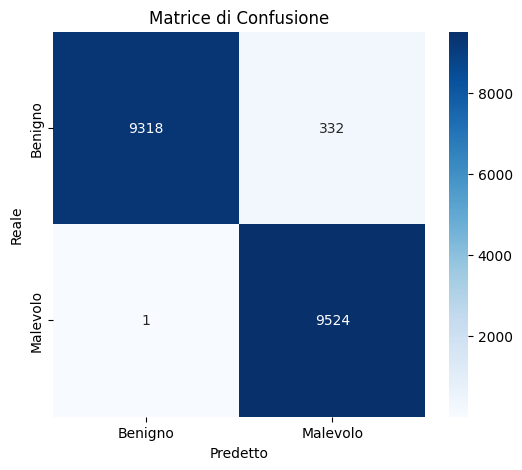

In [9]:
# analysis/evaluate.py

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Get the current working directory (which you set to /content/drive/MyDrive/Github/ProgettoRL/)
project_root = os.getcwd()

# Append the directories containing the modules to sys.path
sys.path.append(os.path.join(project_root, 'preprocessing'))
sys.path.append(os.path.join(project_root, 'rl'))
sys.path.append(os.path.join(project_root, 'config'))

# Make sure stable_baselines3 is installed
try:
    from stable_baselines3 import PPO
except ImportError:
    print("stable_baselines3 not found. Installing...")
    !pip install stable_baselines3
    from stable_baselines3 import PPO

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from rl.environment import NetworkEnv
from preprocessing.data_loader import load_data, preprocess_data
from config.params import PARAMS


def main():
    print("\n[🔄] Caricamento dataset...")
    df = load_data(PARAMS["data_dir"])

    print("Label distribution in full dataset:")
    print(Counter(df[PARAMS["label_column"]]))

    print("\n[🧮] Preprocessing...")
    _ , X_test, y_train, y_test = preprocess_data(
        df, PARAMS["feature_columns"], PARAMS["label_column"]
    )

    print("Label distribution after preprocessing:")
    train_counter = Counter(y_train)
    test_counter = Counter(y_test)

    print(f"Train: {train_counter}")
    print(f"Test:  {test_counter}")
    print(f"Total 1s: {train_counter[1]} + {test_counter[1]} = {train_counter[1] + test_counter[1]}")
    print(f"Total 0s: {train_counter[0]} + {test_counter[0]} = {train_counter[0] + test_counter[0]}")

    print("\n[🧠] Carico modello addestrato...")
    try:
        model = PPO.load("../ppo_model")
    except Exception as e:
        print(f"\n[❌] Errore nel caricare il modello: {e}")
        return

    print("\n[🧪] Valutazione modello...")
    env = NetworkEnv(X_test, y_test)
    obs = env.reset()
    print(f"\n[🔍] Primo stato: {obs}")
    print(f"\n[📊] Dimensione osservazione: {obs.shape}")

    predictions = []
    true_labels = []

    for _ in range(len(X_test)):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = env.step(action)
        predictions.append(action)
        true_labels.append(env.labels[env.current_step - 1])
        if done:
            break

    print("\n[📊] METRICHE DI VALUTAZIONE:")
    print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")
    print(f"Precision: {precision_score(true_labels, predictions):.4f}")
    print(f"Recall: {recall_score(true_labels, predictions):.4f}")
    print(f"F1 Score: {f1_score(true_labels, predictions):.4f}")

    print("\n[📋] CLASSIFICATION REPORT:")
    print(classification_report(true_labels, predictions, digits=4))

    print("\n[🔢] CONFUSION MATRIX:")
    cm = confusion_matrix(true_labels, predictions)
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Benigno", "Malevolo"],
        yticklabels=["Benigno", "Malevolo"],
    )
    plt.xlabel("Predetto")
    plt.ylabel("Reale")
    plt.title("Matrice di Confusione")
    # plt.savefig("confusion_matrix.png")
    plt.show()

    df_results = pd.DataFrame({
        "true_label": true_labels,
        "predicted": predictions
    })
    df_results.to_csv("evaluation_results.csv", index=False)

if __name__ == "__main__":
    main()
